# A Comparision Between Complete State Tomography and Shadow Tomography

## Complete State Tomography

### Overview

The aim of complete state tomography is to reconstruct a target quantum state through a series of projective measurements. *Mention Born's rule, destruction of a state due to measurement, and the curse of dimensionality.*

### Theory

For single-qubit states the general expression for their density matrices can be written uniquely as:
$$\hat{\rho} = \frac{1}{2} \sum_{i=0}^{3} S_i \hat{\sigma}_i. \tag{1}$$
Where $\hat{\sigma}_i$ are the Pauli matrices (Including the 2x2 identity matrix as $\hat{\sigma}_0$) and $S_i$ are the values given by:
$$S_i = Tr\{\hat{\sigma}_i\hat{\rho}\}. \tag{2}$$
It is also useful to note that, 
1. For all pure states: $\sum_{i=1}^{3} S_i^2 = 1$.
2. For mixed states: $\sum_{i=1}^{3} S_i^2 < 1$.
3. For the completely mixed state:  $\sum_{i=1}^{3} S_i^2 = 0$.
4. Due to the normalization condition for quantum states it is always the case that: $S_0^2 = 1$.

The above contents are from pages 4 and 5 of [Quantum State Tomography](#references). Proofs of (1) and (2) to be added in the future.

For a quantum state represented by density matrix $\hat{\rho}$ the expectation value for an observable $\hat{\Omega}$ is given by:
$$\langle \hat{\Omega} \rangle = \sum_{i} p_i \bra{i} \hat{\Omega} \ket{i} = Tr \{ \hat{\Omega} \hat{\rho} \}. \tag{3}$$
Thus, using (1) and (3), we can represent the density matrix for a single-qubit state as:
$$\hat{\rho} = \frac{1}{2} \sum_{i=0}^{3} \langle \hat{\sigma}_i \rangle \hat{\sigma}_i. \tag{4}$$

For multiple-qubit states the general expression for their density matrices can be written as:
$$ \hat{\rho} = \frac{1}{2^n} \sum_{i_1,i_2,\dots,i_n = 0}^{3} S_{i_1,i_2,\dots,i_n} \hat{\sigma_{i_1}} \otimes \hat{\sigma_{i_2}} \otimes \dots \hat{\sigma_{i_n}}. \tag{5}$$
Where $\hat{\sigma}_i$ are still the Pauli matrices (Including the 2x2 identity matrix as $\hat{\sigma}_0$) and $S_{i_1,i_2,\dots,i_n}$ are the values given by:
$$ S_{i_1,i_2,\dots,i_n} = Tr\{ \hat{\sigma}_{i_1,i_2,\dots,i_n} \hat{\rho} \} = Tr\{ (\hat{\sigma_{i_1}} \otimes \hat{\sigma_{i_2}} \otimes \dots \hat{\sigma_{i_n}}) \hat{\rho} \} \tag{6}$$

The above contents are from page 11 of [Quantum State Tomography](#references).

> Note: Above we only considered the orthogonal measurement bases of the pauli matrices. We are not constrained to orthogonal measurement bases and can instead use any set of linearly independent projective measurements (see pages 5 and 6 of [Quantum State Tomography](#references) for the single-qubit case and pages 11 and 12 of [Quantum State Tomography](#references) for the multiple-qubit case.).

### The "Algorithm"

#### Importing necessary libraries

In [3]:
import numpy as np
import itertools

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit import Clbit
from qiskit.circuit.library import *
from qiskit.primitives import StatevectorSampler, Estimator
from qiskit.quantum_info import DensityMatrix

#### Function for generating an approximation of the $\rho$ prepared by the input circuit using complete state tomography as describe in [Quantum State Tomography](#references) (Work in Progress)

In [46]:
def complete_state_tomography(circuit, samples, num_qubits):
    """
    Perform complete state tomography on a state prepared by a quantum circuit.

    Args:
        circuit (QuantumCircuit): The quantum circuit that prepares the state.
        samples (int): The number of samples to use in the tomography.
        num_qubits (int): The number of qubits in the circuit.

    Returns:
        np.ndarray: The density matrix of the state.
    """

    # The Pauli matrices.
    I = [[1,0],[0,1]]
    X = [[0,1],[1,0]]
    Y = [[0,-1j],[1j,0]]
    Z = [[1,0],[0,-1]]

    # Create a matrix to store the density matrix.
    rho = np.zeros((2**num_qubits, 2**num_qubits), dtype=complex)

    # Generate the measurement scheme using the cartesian product.
    measurement_scheme = itertools.product(['I','X','Y','Z'], repeat=num_qubits)

    measurements = []
    # Store the values of the interator in an array.
    for m in measurement_scheme:
        measurements.append(m)

    # An array to store the measurement results.
    results = np.zeros(4**num_qubits)

    # Create a sampler to simulate the quantum circuit on a single shot.
    estimator = Estimator(options = ({'shots':samples}))

    # Perform the measurements.
    for n, measurement in enumerate(measurements):
        
        # Run the sampler on the quantum circuit and store the result.
        results[n] = estimator.run(circuits = [circuit], observables = [''.join(measurement)]).result().values[0]
        
        # Calculate the density matrix.
        for i, measurement in enumerate(measurements):

            o = [1]
            for j in measurement:
                match j:
                    case 'I':
                        o = np.kron(o, I)
                    case 'X':
                        o = np.kron(o, X)
                    case 'Y':
                        o = np.kron(o, Y)
                    case 'Z':
                        o = np.kron(o, Z)
            rho += results[i] * o

    return rho/2**num_qubits

### Examples

#### With a Bell state

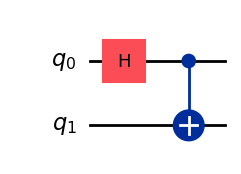

In [37]:
num_qubits = 2
bell_state = [1/np.sqrt(2), 0, 0, 1/np.sqrt(2)]

# Instantiate a quantum register with two qubits.
bell_state_qr = QuantumRegister (num_qubits, 'q')

# Create a quantum circuit with a hadamard gate acting on qubit 0
# and a CNOT gate with control qubit 0 and target qubit 1. This will prepare a bell state.
bell_state_qc = QuantumCircuit(bell_state_qr)
bell_state_qc.h(0)
bell_state_qc.cx(0, 1)

# Draw the ciruit in mpl (matplotlib).
bell_state_qc.draw("mpl")

In [47]:
rho_true = DensityMatrix.from_instruction(bell_state_qc)
print(rho_true)

rho_tomo = complete_state_tomography(bell_state_qc, 1000, num_qubits)
print(np.round(rho_tomo, 2))

DensityMatrix([[0.5+0.j, 0. +0.j, 0. +0.j, 0.5+0.j],
               [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j],
               [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j],
               [0.5+0.j, 0. +0.j, 0. +0.j, 0.5+0.j]],
              dims=(2, 2))
[('I', 'I'), ('I', 'X'), ('I', 'Y'), ('I', 'Z'), ('X', 'I'), ('X', 'X'), ('X', 'Y'), ('X', 'Z'), ('Y', 'I'), ('Y', 'X'), ('Y', 'Y'), ('Y', 'Z'), ('Z', 'I'), ('Z', 'X'), ('Z', 'Y'), ('Z', 'Z')]
('I', 'I')
('I', 'X')
('I', 'Y')
('I', 'Z')
('X', 'I')
('X', 'X')
('X', 'Y')
('X', 'Z')
('Y', 'I')
('Y', 'X')
('Y', 'Y')
('Y', 'Z')
('Z', 'I')
('Z', 'X')
('Z', 'Y')
('Z', 'Z')
('I', 'I')
('I', 'X')
('I', 'Y')
('I', 'Z')
('X', 'I')
('X', 'X')
('X', 'Y')
('X', 'Z')
('Y', 'I')
('Y', 'X')
('Y', 'Y')
('Y', 'Z')
('Z', 'I')
('Z', 'X')
('Z', 'Y')
('Z', 'Z')
('I', 'I')
('I', 'X')
('I', 'Y')
('I', 'Z')
('X', 'I')
('X', 'X')
('X', 'Y')
('X', 'Z')
('Y', 'I')
('Y', 'X')
('Y', 'Y')
('Y', 'Z')
('Z', 'I')
('Z', 'X')
('Z', 'Y')
('Z', 'Z')
('I', 'I')
('I', 'X')
('I', 'Y')
('I', 

## Shadow Tomography

### Overview

### Theory

## The Method of Classical Shadows

### The "Algorithm"

#### Importing necessary libraries

In [5]:
import numpy as np
import itertools

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit import Clbit
from qiskit.circuit.library import *
from qiskit.primitives import StatevectorSampler, Estimator
from qiskit.quantum_info import DensityMatrix

#### Function for generating the classical shadow

In [6]:
def generate_classical_shadow(circuit, shadow_size, num_qubits):
    """
    Adapted from https://pennylane.ai/qml/demos/tutorial_classical_shadows/
    Given a quantum circuit, this function creates a collection of bitstrings generated by random single-qubit Pauli measurements and records the associated random pauli measurment.

    Args:
        circuit (QuantumCircuit): The quantum circuit which resulting state we wish to estimate.
        shadow_size (int): The number of random Pauli measurements to be taken.
        num_qubits (int): The number of qubits in the circuit.

    Returns:
        np.ndarray: A matrix of shape (shadow_size, num_qubits) where each row is a bitstring representing the result of a random Pauli measurement on the qubits.
        np.ndarray: A matrix of shape (shadow_size, num_qubits) where each row is a sequence of integers representing the Pauli measurement scheme used to generate the corresponding bitstring in the first matrix.
    """

    # Generate the measurment scheme. This is the random Pauli measurements that will be done on the qubits after each shot of the circuit.
    measurement_scheme = np.random.randint(0, 3, size = (shadow_size, num_qubits))

    # Create a matrix to store the results of the measurements.
    measurements = np.zeros(shape = (shadow_size, num_qubits))

    # Create a sampler to simulate the quantum circuit on a single shot.
    sampler = StatevectorSampler(default_shots=1)

    # 
    for i in range(shadow_size):

        # Apply the measurement scheme to the qubits
        qc = QuantumCircuit.copy(circuit)

        for j in range(num_qubits):
            if measurement_scheme[i][j] == 0:
                qc.h(j)
            elif measurement_scheme[i][j] == 1:
                qc.h(j)
                qc.sdg(j)
            else:
                continue

        qc.measure_all()

        # Run the sampler on the quantum circuit and store the result.
        result = sampler.run([qc]).result()[0]

        # Store the bitstrings representing the measured basis states. Because the sampler is configered to run the circuit once, there is only one result.
        counts = result.data.meas.get_counts()   

        # Get the single bitstring.
        states = list(list(counts.keys())[0])
        # The bit string is ordered with qubit n on the left and qubit 0 on the right. We want to reverse this order.
        states.reverse()

        # Store the results of the measurements.
        for j in range(num_qubits):
            measurements[i][j] = 0 if states[j] == '0' else 1

    return measurements, measurement_scheme

#### Function for reconstructing the states density matrix from the classical shadow

This is not the intended use of the classical shadow protocol and is additionally not the goal of shadow tomography. However, it serves as a useful test of the functionality of the generation of classical shadows.

In [7]:
def reconstruct_state(shadow):
    """
    Adapted from https://pennylane.ai/qml/demos/tutorial_classical_shadows/
    Given a classical shadow, this function reconstructs an approximation of the density matrix of the quantum state.
    
    Args:
        shadow (np.array): An array of shape (shadow_size, num_qubits) where each element is a tuple of the form (b, unitary_index) where b is the measured basis state in the computational basis and unitary_index is the index of the Pauli operator applied to the qubit.

    Returns:
        np.array: An approximation of the density matrix of the quantum state.
    """

    # Unpack the shadow.
    measurements, measurement_scheme = shadow

    # Get the shadow size.
    shadow_size = measurements.shape[0]
    # Get the number of qubits.
    num_qubits = measurements.shape[1]

    # Computational basis states.
    zero_state = np.matrix([[1,0],[0,0]], dtype=complex)
    one_state = np.matrix([[0,0],[0,1]], dtype=complex)

    # Local qubit unitaries. 
    phase_z = np.matrix([[1,0],[0,-1j]], dtype=complex)
    hadamard = np.matrix([[1,1],[1,-1]], dtype=complex)/np.sqrt(2)
    identity = np.matrix([[1,0],[0,1]], dtype=complex)

    # Rotations to measure each of the paulis.
    X = hadamard
    Y = hadamard @ phase_z
    Z = identity

    # Tomographically complete set of unitaries. (The pauli basis is tomographically complete.) 
    unitary_ensemble = [X, Y, Z]

    # Array to store the estimated density matrix.
    rho_estimated = np.zeros((2**num_qubits, 2**num_qubits), dtype=complex)

    for i in range(shadow_size):

        # Array to store the density matrix at each snapshot.
        rho_snapshot = [1]

        for j in range(num_qubits):

            # Implementation of formula S44 from the preskill paper.
            U = unitary_ensemble[measurement_scheme[i][j]]
            if measurements[i][j] == 0:
                b_state = zero_state
            else:
                b_state = one_state

            rho_local = 3 * (U.H @ b_state @ U) - identity

            rho_snapshot = np.kron(rho_snapshot, rho_local)

        # Average all the inverted basis states to get an approximation of the density matrix.

        rho_estimated += rho_snapshot

    return rho_estimated/shadow_size

> Note: In my implementation of the classical shadow protocol I use a measurement procedure consisting of random single-qubit Clifford circuits (which are equivalent to measuring a random Pauli observable). I chose this procedure due its ease of implementation but other procedures offer different benefits, some of which are disused in [Predicting Many Properties of a Quantum System from Very Few Measurements](#references).

### Testing the shadow generation and state reconstruction. 

Using the function ``operator_distance`` we can determine how "close" the reconstructed state is to the true state.

In [8]:
def operator_distance(A, B):
    """
    Calculate the distance between two operators using the Frobenius norm.

    Args:
        A (np.array): The first operator.
        B (np.array): The second operator.

    Returns:
        float: The distance between the two operators.
    """

    return np.linalg.norm((A - B), ord = 'fro')

## The Single Qubit Case

## The Two Qubit Case

## The Three Qubit Case

## References
1. [Predicting Many Properties of a Quantum System from Very Few Measurements](https://arxiv.org/pdf/2002.08953)
2. [Quantum State Tomography](https://research.physics.illinois.edu/QI/Photonics/tomography-files/tomo_chapter_2004.pdf)
3. [PennyLane Classical Shadows Demo](https://pennylane.ai/qml/demos/tutorial_classical_shadows/#huang2020)